In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mask-test/mask.jpeg
/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotation

In [2]:
# import libs
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

**Dir paths:**

In [3]:
images ='/kaggle/input/face-mask-detection/images/'
annot ='/kaggle/input/face-mask-detection/annotations/'

**images read**

In [4]:
# imges_read=[]
# for img in os.listdir(images):
#     image=cv2.imread(os.path.join(images,img))
#     image=cv2.resize(image, (250,250),interpolation = cv2.INTER_LINEAR)
#     imges_read.append(image)


In [5]:
# imges_read[4].shape

In [6]:
# df={}

## Check data 

In [7]:
import os
from PIL import Image

# Define the criteria for a "good" image
MIN_WIDTH = 100
MIN_HEIGHT = 100
ALLOWED_FORMATS = ['jpeg', 'png']

# Path to the directory containing images
image_directory = images

# Iterate through the directory tree using os.walk
for root, dirs, files in os.walk(image_directory):
    for file in files:
        # Check if the file has an allowed format
        if file.lower().endswith(tuple(ALLOWED_FORMATS)):
            # Get the full path to the image
            image_path = os.path.join(root, file)

            # Open the image using PIL
            try:
                img = Image.open(image_path)
                img_width, img_height = img.size
                
                # Check if the image meets the size criteria
                if img_width >= MIN_WIDTH and img_height >= MIN_HEIGHT:
#                     print(f"Good image: {image_path}")
                    continue
                else:
                    print(f"Image dimensions too small: {image_path}")
            except Exception as e:
                print(f"Error opening image {image_path}: {e}")


In [8]:
import xml.etree.ElementTree as ET

def check_xml_syntax(xml_path):
    try:
        ET.parse(xml_path)
#         print(f"{xml_path} has valid XML syntax.")
    except ET.ParseError as e:
        print(f"Error in {xml_path}: {e}")

xml_files_directory = annot
for root, dirs, files in os.walk(xml_files_directory):
    for file in files:
        if file.lower().endswith('.xml'):
            xml_path = os.path.join(root, file)
            check_xml_syntax(xml_path)


## prepare data

In [9]:
label2category = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}
category2label = {v: k for k, v in label2category.items()}
datas = []

for root, dirs, files in os.walk(annot):
    for file in files:
        tree = ET.parse(os.path.join(root, file))
        data = {'path': None, 'objects': []}
        data['path'] = os.path.join(images, tree.find('filename').text)
        for obj in tree.findall('object'):
            label = label2category[obj.find('name').text]
            # top left co-ordinates
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            # bottom right co-ordinates
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            data['objects'].append([label, xmin, ymin, xmax, ymax])
        datas.append(data)    
len(datas)

853

In [114]:
img_size = (100, 100)
X = []
Y = []

for data in datas:
    img = cv2.imread(data['path'])
    for (category, xmin, ymin, xmax, ymax) in data['objects']:
        roi = img[ymin : ymax, xmin : xmax]
        roi = cv2.resize(roi,img_size)
        data = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        target = to_categorical(category, num_classes=len(category2label))
        X.append(data)
        Y.append(target)
        
X = np.array(X)
Y = np.array(Y)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [97]:
# from sklearn.model_selection import train_test_split
X[8].shape

(100, 100, 3)

In [98]:
Y[0]

array([0., 1., 0.], dtype=float32)

In [99]:
!pip install tensorflow

In [146]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
model = Sequential()

base_model= ResNet50(include_top=False,
                   input_shape=(100,100,3),
                   pooling='avg',classes=3,
                   weights='imagenet')

In [147]:
base_model.trainable = True

for layer in base_model.layers:
      layer.trainable = True
for layer in base_model.layers:#[:3]:
        layer.trainable=False

In [148]:
from tensorflow.keras.optimizers import Adam

model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(3, activation='softmax'))

In [149]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_18 (Dropout)        (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 100)               204900    
                                                                 
 dropout_19 (Dropout)        (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 3)                 303       
                                                                 
Total params: 23,792,915
Trainable params: 205,203
Non

In [150]:
import tensorflow as tf
model.compile(optimizer='rmsprop',
             loss=tf.keras.losses.categorical_crossentropy,
             metrics=['accuracy'])

In [151]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=.3)

In [152]:
history = model.fit(
      x=X_train,y=y_train,
      epochs=13,validation_split=.2
     )

Epoch 1/13
72/72 [==============================] - 8s 54ms/step - loss: 0.6037 - accuracy: 0.8338 - val_loss: 0.2624 - val_accuracy: 0.9368
Epoch 2/13
72/72 [==============================] - 3s 36ms/step - loss: 0.3672 - accuracy: 0.8952 - val_loss: 0.2252 - val_accuracy: 0.9333
Epoch 3/13
72/72 [==============================] - 3s 36ms/step - loss: 0.3574 - accuracy: 0.9000 - val_loss: 0.1968 - val_accuracy: 0.9368
Epoch 4/13
72/72 [==============================] - 3s 38ms/step - loss: 0.2854 - accuracy: 0.9175 - val_loss: 0.2249 - val_accuracy: 0.9298
Epoch 5/13
72/72 [==============================] - 3s 36ms/step - loss: 0.2937 - accuracy: 0.9136 - val_loss: 0.2023 - val_accuracy: 0.9368
Epoch 6/13
72/72 [==============================] - 3s 36ms/step - loss: 0.2842 - accuracy: 0.9118 - val_loss: 0.1981 - val_accuracy: 0.9491
Epoch 7/13
72/72 [==============================] - 3s 36ms/step - loss: 0.2526 - accuracy: 0.9237 - val_loss: 0.1787 - val_accuracy: 0.9509
Epoch 8/13
72

## TEST

In [200]:
model.evaluate(
    x=X_test,
    y=y_test)

39/39 [==============================] - 1s 31ms/step - loss: 0.2430 - accuracy: 0.9272


[0.24300357699394226, 0.9271685481071472]

In [240]:
list1=os.listdir('/kaggle/input/testdatanew/')+os.listdir('/kaggle/input/testdata/')
list1

['without5.jpeg',
 'mask1.jpeg',
 'without3.png',
 'mask23.jpeg',
 'without.png',
 'mask2.jpeg',
 'without2.jpeg',
 'without.jpeg']

In [256]:
test_data=[]
for i in os.listdir('/kaggle/input/testdata/'):
    img = cv2.imread(os.path.join('/kaggle/input/testdata/',i))
    roi = cv2.resize(img,(100,100))
    data = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    test_data.append(data)

In [257]:
pred_test=[]
for i in (test_data):
    # Assuming your input data is named 'input_data' with shape (None, 100, 3)
    reshaped_data = np.expand_dims(i, axis=2)  # Shape becomes (None, 100, 1, 3)
    prepared_data = np.repeat(reshaped_data, 100, axis=2)  # Shape becomes (None, 100, 100, 3)

    # Make the prediction
    predictions = model.predict(prepared_data)
    pred_test.append(predictions)

4/4 [==============================] - 0s 26ms/step


In [258]:
lastpred=[]
for i in pred_test:
    lastpred.append(i.argmax(axis=1)[0])
    

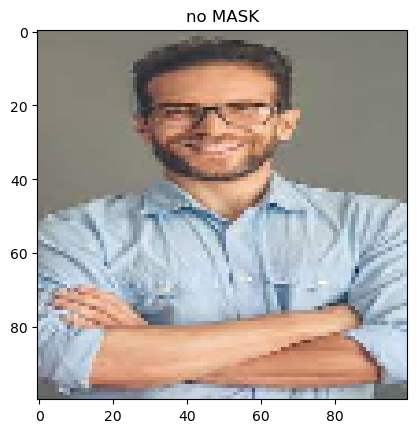

In [262]:
mask_label = {0:'no MASK',1:'MASK',2:'not right'}
dist_label = {0:(0,255,0),1:(255,0,0)}
# cv2.putText(img,mask_label[predictions.argmax(axis=1)[0]])
# for i in test_data:
# plt.imshow(test_data[0])
plt.imshow(test_data[1])
plt.title(mask_label[lastpred[1]]);